In [1]:
import pandas as pd
import geopandas as gpd
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import wkt
from sklearn.preprocessing import RobustScaler, normalize
from typing import List



In [2]:
gdf = pd.read_parquet('Datasets\processed_data.parquet')
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs='EPSG:4326')
gdf['duration'] = (gdf['datetime'] - gdf['outagestarttime']).dt.total_seconds() / 3600
gdf.columns

Index(['outagenumber', 'estcustaffected', 'outagestarttime', 'datetime',
       'cause', 'latitude_x', 'longitude_x', 'regionname', 'geometry',
       'zip_code', 'po_name', 'population', 'pop_sqmi', 'county_name',
       'centroid_lat', 'centroid_lon', 'temperature_2m',
       'relative_humidity_2m', 'precipitation', 'rain', 'snowfall',
       'snow_depth', 'weather_code', 'wind_speed_10m', 'wind_direction_10m',
       'wind_gusts_10m', 'latitude_y', 'longitude_y', 'NAME_acs', 'median_age',
       'female_65_to_74', 'female_75_to_84', 'female_85_plus', 'male_65_to_74',
       'male_75_to_84', 'male_85_plus', 'total_population_disability_status',
       'under_18_with_disability', 'age_18_64_with_disability',
       'over_65_with_disability', 'civilian_noninst_population',
       'no_health_insurance', 'median_household_income',
       'family_income_past_12months', 'income_below_poverty',
       'median_home_value', 'total_housing_units', 'vacant_housing_units',
       'house_heating_

In [3]:
gdf['GEOID'].nunique()

3219

Processing

In [4]:
#remove everything below 100, 
gdf = gdf[gdf['total_population'] > 100]
#anything with incorrect datetime
gdf = gdf[gdf['outagestarttime'] < gdf['datetime']]
gdf = gdf[gdf['outagestarttime'] > pd.to_datetime('2018-01-01')]


In [5]:
nan_cols = gdf.isna().sum()
print(nan_cols[nan_cols != 0].index.tolist())

[]


In [6]:
gdf.dropna()
gdf

KeyboardInterrupt: 

In [8]:
gdf[[ 'latitude_x', 'longitude_x', 'geometry','latitude_y', 'longitude_y']]

,latitude_x,longitude_x,geometry,latitude_y,longitude_y
0,37.35269,-121.82072,POINT (-121.82072 37.35269),37.232052,-121.695631
1,37.35269,-121.82072,POINT (-121.82072 37.35269),37.232052,-121.695631
2,37.35269,-121.82072,POINT (-121.82072 37.35269),37.232052,-121.695631
3,37.35269,-121.82072,POINT (-121.82072 37.35269),37.232052,-121.695631
4,37.41311,-121.86312,POINT (-121.86312 37.41311),37.232052,-121.695631
...,...,...,...,...,...
1443667,38.01848,-121.21436,POINT (-121.21436 38.01848),37.934678,-121.271348
1443668,38.00350,-121.22154,POINT (-121.22154 38.0035),37.934678,-121.271348
1443669,38.00350,-121.22154,POINT (-121.22154 38.0035),37.934678,-121.271348
1443670,38.00350,-121.22154,POINT (-121.22154 38.0035),37.934678,-121.271348


In [ ]:
gdf[[ 'latitude_x', 'longitude_x']]

In [9]:
output_path = 'Datasets/pge_outages.geojson'  # Adjust path as needed
gdf.to_file(output_path, driver='GeoJSON')
print(f"GeoJSON file successfully exported to {output_path}")

GeoJSON file successfully exported to Datasets/pge_outages.geojson


Data Validation:
1) Population is Consistent 
2) Outage Start Date <= Outage time
3) NaN and Null

13860665.0 
 4312.590230242688 
 125.0 



Text(0.5, 1.0, 'Q-Q Plot')

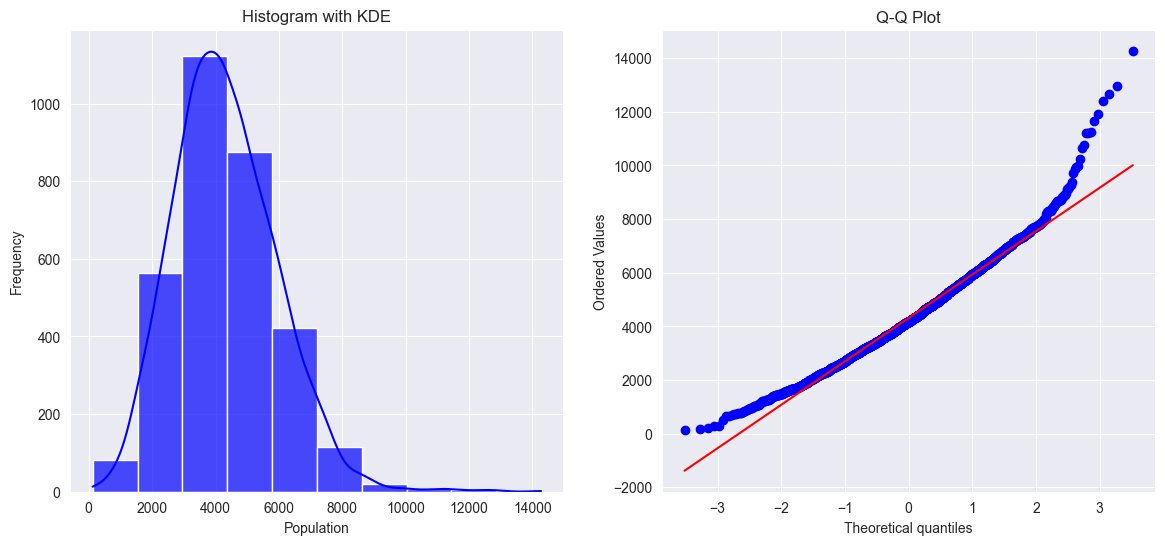

In [28]:
pop_tract = gdf.groupby('GEOID').first()["total_population"]
print(pop_tract.sum(), "\n", 
      pop_tract.mean(), "\n",
      pop_tract.min(), "\n",)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(pop_tract, bins=10, kde=True, color='blue', alpha=0.7, ax=axes[0])
axes[0].set_title("Histogram with KDE")
axes[0].set_xlabel("Population")
axes[0].set_ylabel("Frequency")
stats.probplot(pop_tract, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot")

After eliminating the deficient ones we can see that the nulls were also eliminated>
PGE Reports 5.5 million consumers, the population data includes people that are not directly consumers so how should I determine the number of consumers per tract?
1) An initial approach could be just assuming that a little bit less than half (5/13.8 = 0.36%) og the population in the tract are consumers => let's go with this
2) The second approach is to get demographic data and make assumptions such as the population between 18-90 will be the consumers.
      
Outage Distribution Analysis:
1) Distribution of Number of Outages
2) Distribution of Duration of Outages
3) Distribution of Outages per population and per consumer as defined above

It can be observed that the graphs produced were less than ideal, hard to see, hard to interpret even when normalized to account for outliers.
in fact the predominance of 1s in the number of customers is so high that it skews everything to the left.
I still want to understand how are outages behaving in general:
1) In terms of Duration, Number of Outages, and number of customer
2) In terms of type of outage, is it possible to classify them?
There are some huge outages, I feel like separating them in bins and classifying them.
We can see if we separate them in bins that the number of customer have exponential behaviour, which is to be expected

1443370


estcustaffected
0-2       884850
2-50      400824
100+      103454
50-100     54242
Name: count, dtype: int64

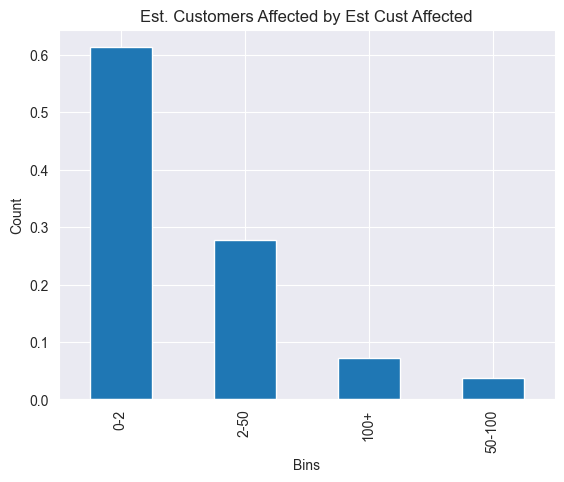

In [41]:
bins = [0, 2, 50,  100, float('inf')]
labels = ['0-2','2-50' ,'50-100', '100+']
bin_counts  = pd.cut(gdf['estcustaffected'], bins=bins, labels=labels, right=False).value_counts()
bin_counts_array = bin_counts.values.reshape(1, -1)  # Convert to 2D array
bin_counts_norm = normalize(bin_counts_array, norm='l1')[0]  # L1 normalization
bin_counts_norm = pd.Series(bin_counts_norm, index=bin_counts.index)
bin_counts_norm.plot(kind='bar', title='Est. Customers Affected by Est Cust Affected', xlabel='Bins', ylabel='Count')
print(gdf.shape[0])
bin_counts


In [80]:
pd.cut(gdf['estcustaffected'], bins=bins, labels=labels, right=False)

0           0-2
1           0-2
2           0-2
3           0-2
4          100+
           ... 
1443667     0-2
1443668     0-2
1443669     0-2
1443670     0-2
1443671     0-2
Name: estcustaffected, Length: 1443370, dtype: category
Categories (4, object): ['0-2' < '2-50' < '50-100' < '100+']

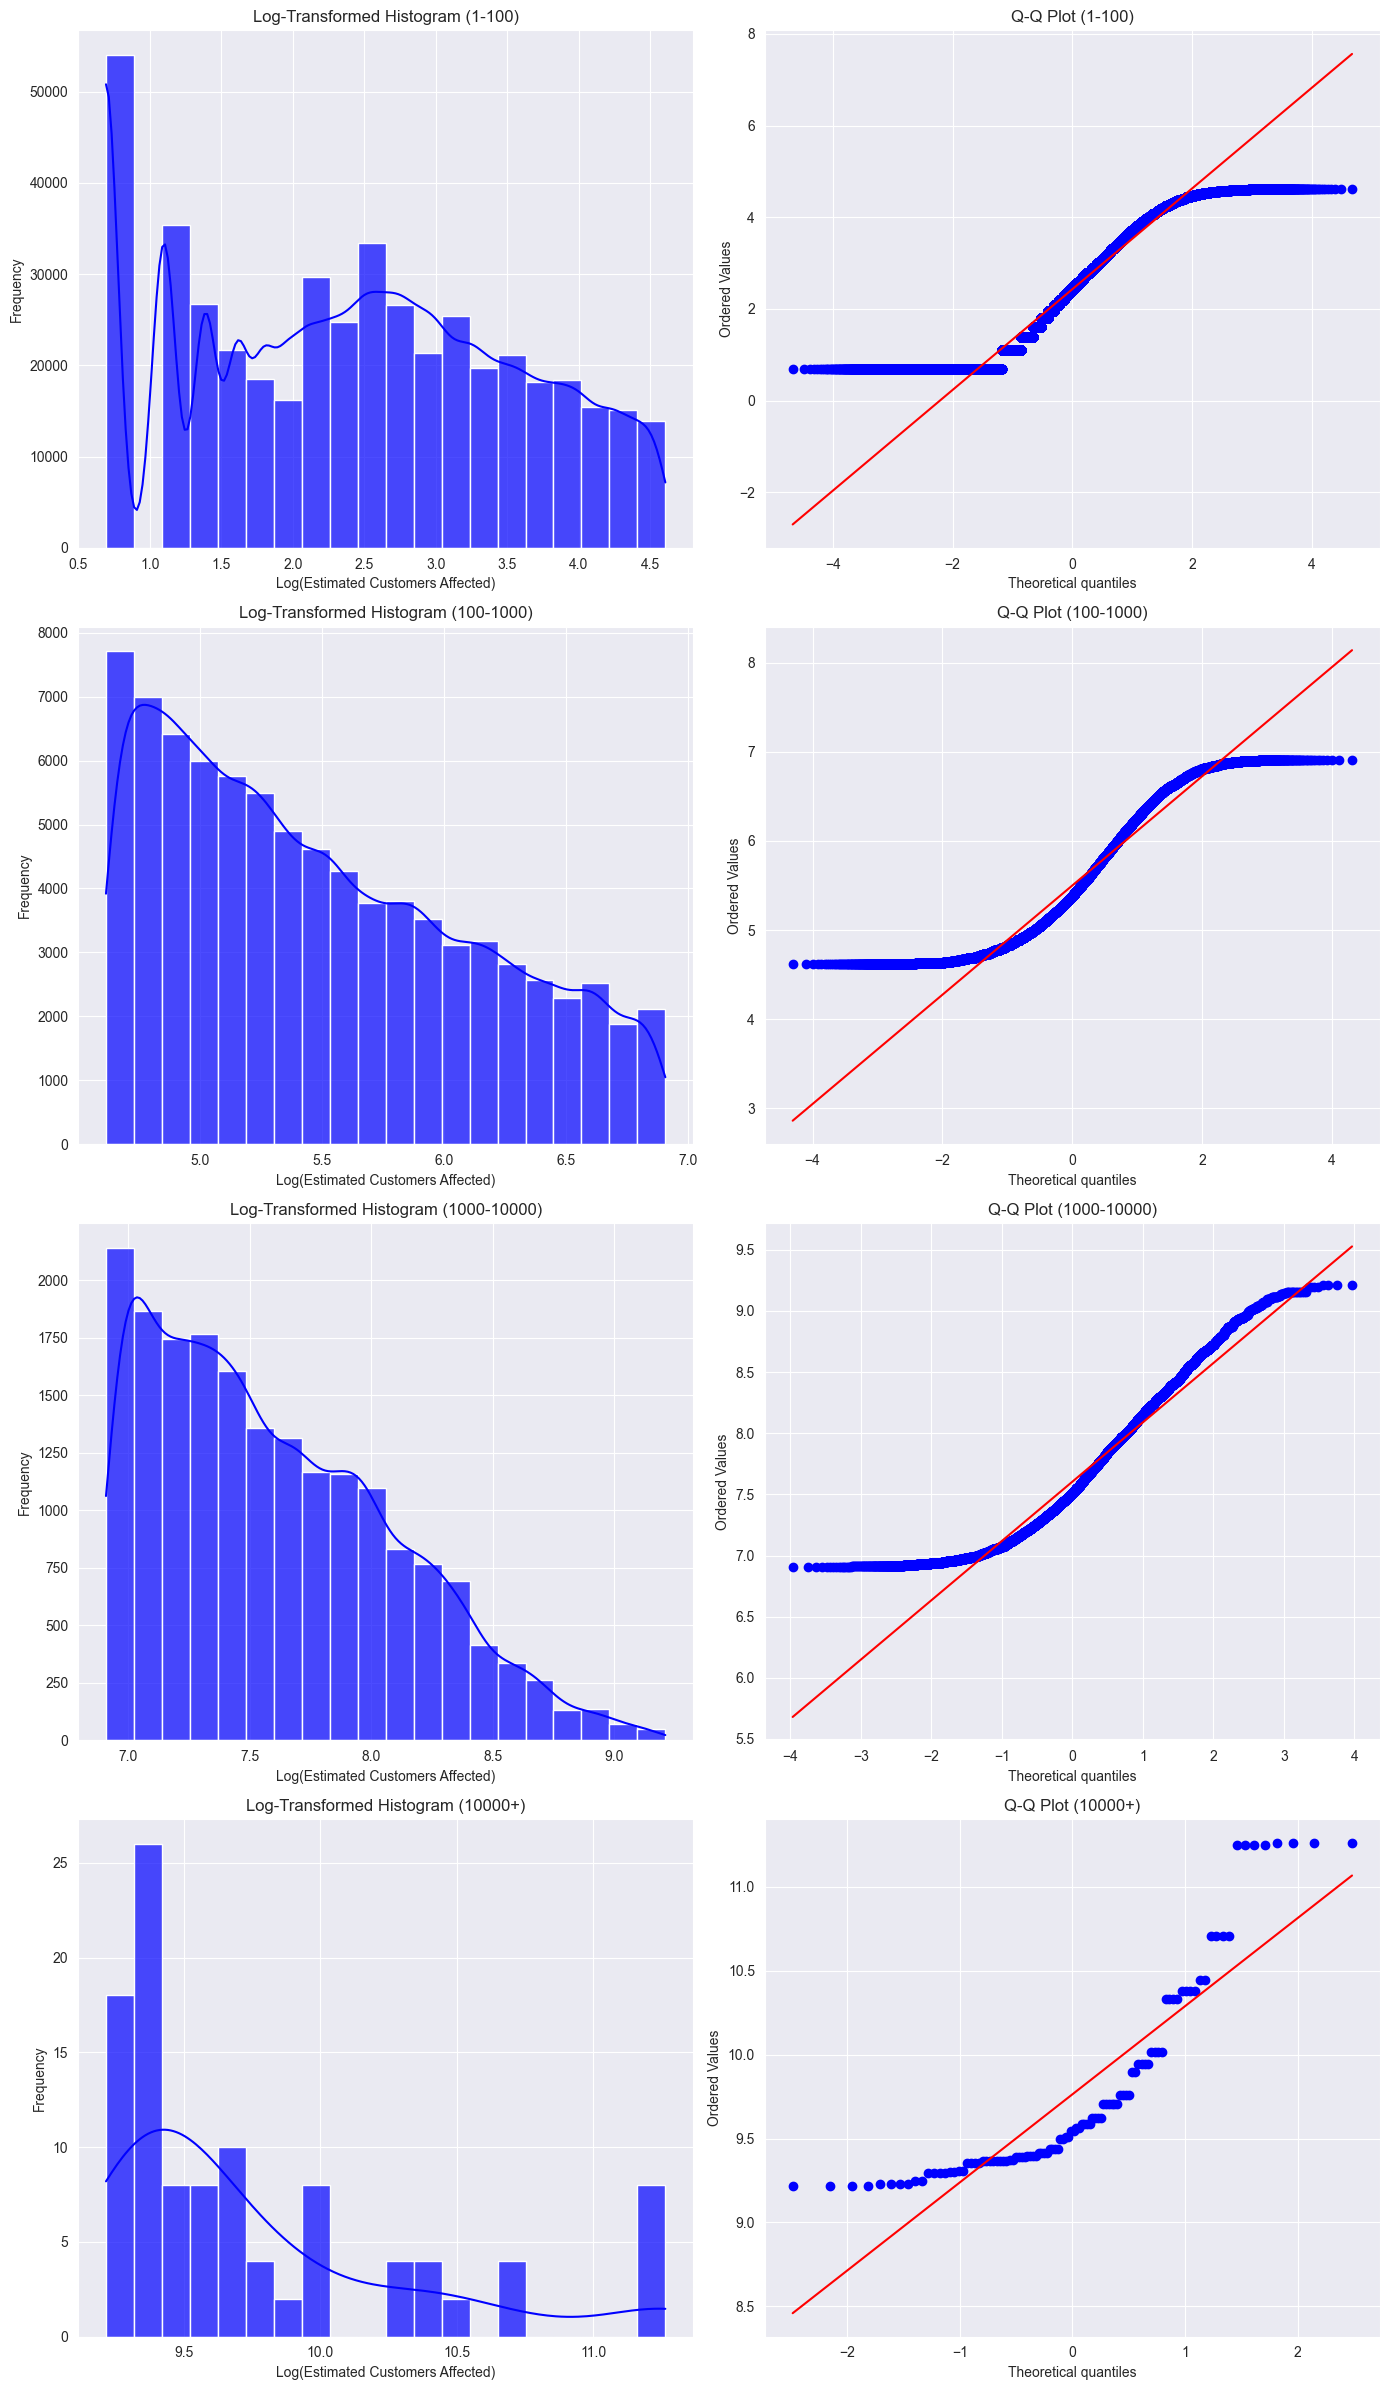

In [75]:
intervals = [(1, 100), (100, 1000), (1000, 10000), (10000, float('inf'))]
interval_labels = ["1-100", "100-1000", "1000-10000", "10000+"]

# Create subplots
fig2, axes = plt.subplots(4, 2, figsize=(14, 24))  # 4 rows, 2 columns

# Loop through intervals
for i, (lower, upper) in enumerate(intervals):
    # Filter data for the current interval
    est_cust_filtered = gdf[(gdf['estcustaffected'] > lower) & (gdf['estcustaffected'] <= upper)]
    if est_cust_filtered.empty:
        continue  # Skip if no data in this range

    # Apply logarithmic transformation
    log_transformed = np.log(est_cust_filtered['estcustaffected'])

    # Histogram with log-transformed data
    sns.histplot(log_transformed, bins=20, kde=True, color='blue', alpha=0.7, ax=axes[i, 0])
    axes[i, 0].set_title(f"Log-Transformed Histogram ({interval_labels[i]})")
    axes[i, 0].set_xlabel("Log(Estimated Customers Affected)")
    axes[i, 0].set_ylabel("Frequency")

    # Q-Q plot with log-transformed data
    stats.probplot(log_transformed, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f"Q-Q Plot ({interval_labels[i]})")

plt.tight_layout()

Now Let's observe the relationship between the number of customers by aff_cust

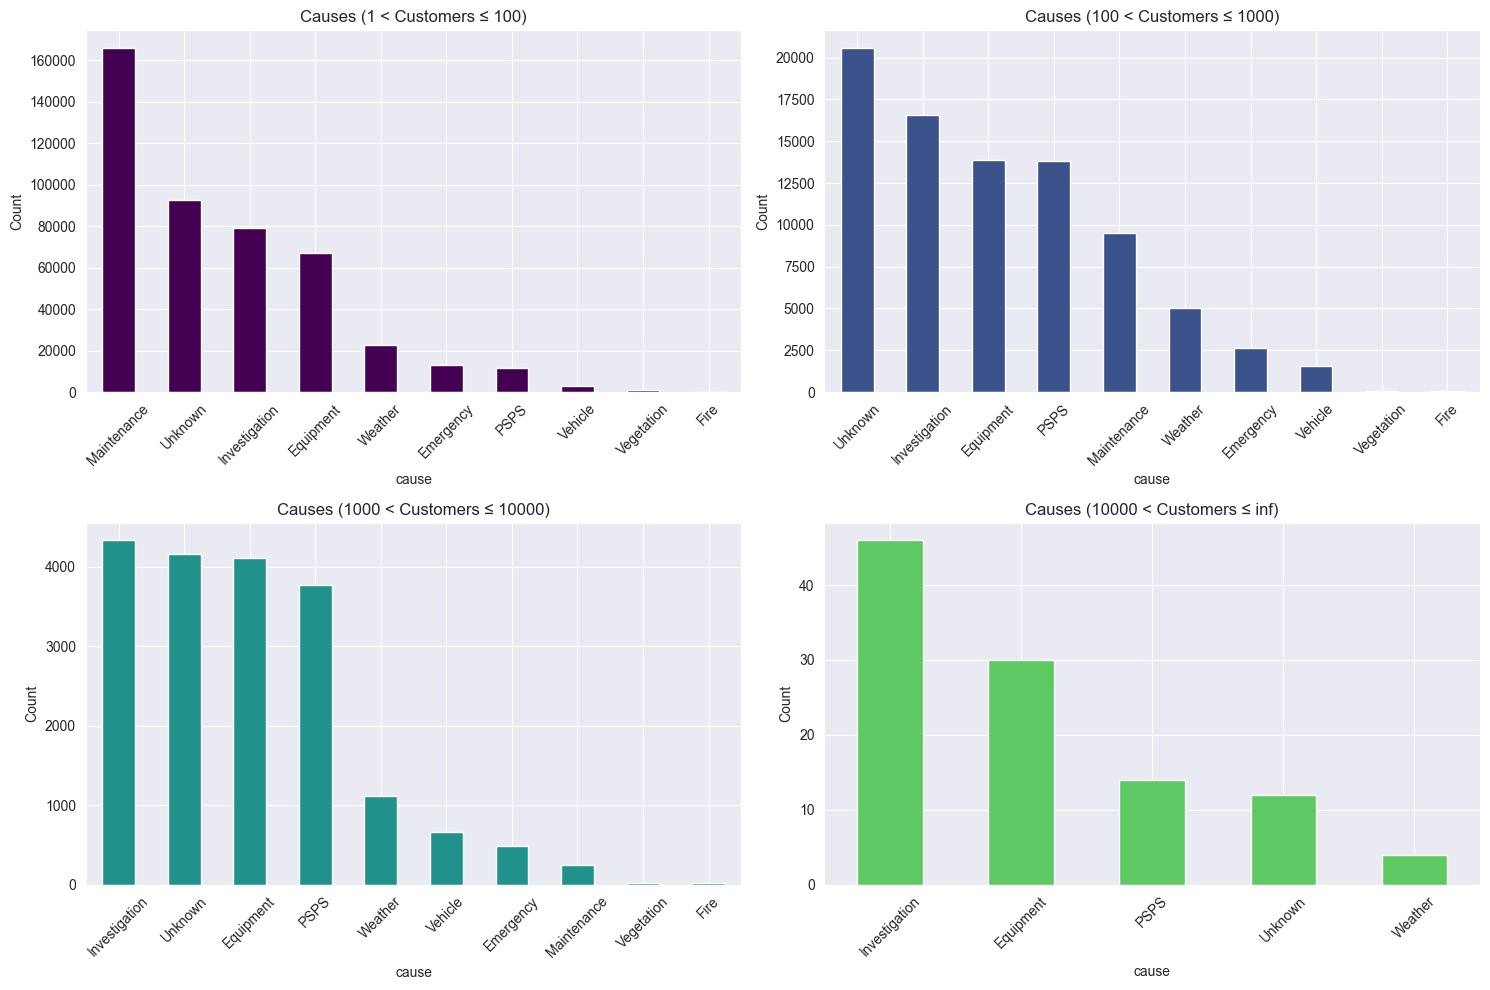

In [139]:
intervals = [(1, 100), (100, 1000), (1000, 10000), (10000, float('inf'))]

plt.tight_layout()
label_map = {
    'Our preliminary determination is that your outage was caused by an equipment issue.': 'Equipment',
    'PG&E is investigating the cause of your outage.': 'Investigation',
    'Our preliminary determination is that your outage was caused by an emergency issue.': 'Emergency',
    'To protect public safety, power in your area has been turned off due to extreme weather conditions with high fire danger. Power will be restored as soon as it is safe to do so.': 'PSPS',
    'Unknown - PG&E will be assessing the cause.': 'Unknown',
    'Our preliminary determination is that your outage was caused by scheduled maintenance work.': 'Maintenance',
    'Our preliminary determination is that your outage was caused by the weather.': 'Weather',
    'Our preliminary determination is that your outage was caused by a fire in your area.': 'Fire',
    'We are clearing vegetation to address potential safety risks in your area.': 'Vegetation',
    'Our preliminary determination is that your outage was caused by a car that hit a pole.': 'Vehicle'
}

fig4, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Create plots for each interval
for interval, ax in zip(intervals, [ax1, ax2, ax3, ax4]):
   mask = (gdf['estcustaffected'] > interval[0]) & (gdf['estcustaffected'] <= interval[1])
   interval_data = gdf[mask]['cause'].map(label_map).value_counts()
   interval_data.plot(kind='bar', ax=ax, color=plt.cm.viridis(intervals.index(interval)/len(intervals)))
   ax.set_title(f'Causes ({interval[0]} < Customers ≤ {interval[1]})')
   ax.tick_params(axis='x', rotation=45)
   ax.set_ylabel('Count')

plt.tight_layout()

First Let's observe if similar phenomenon happens with duration

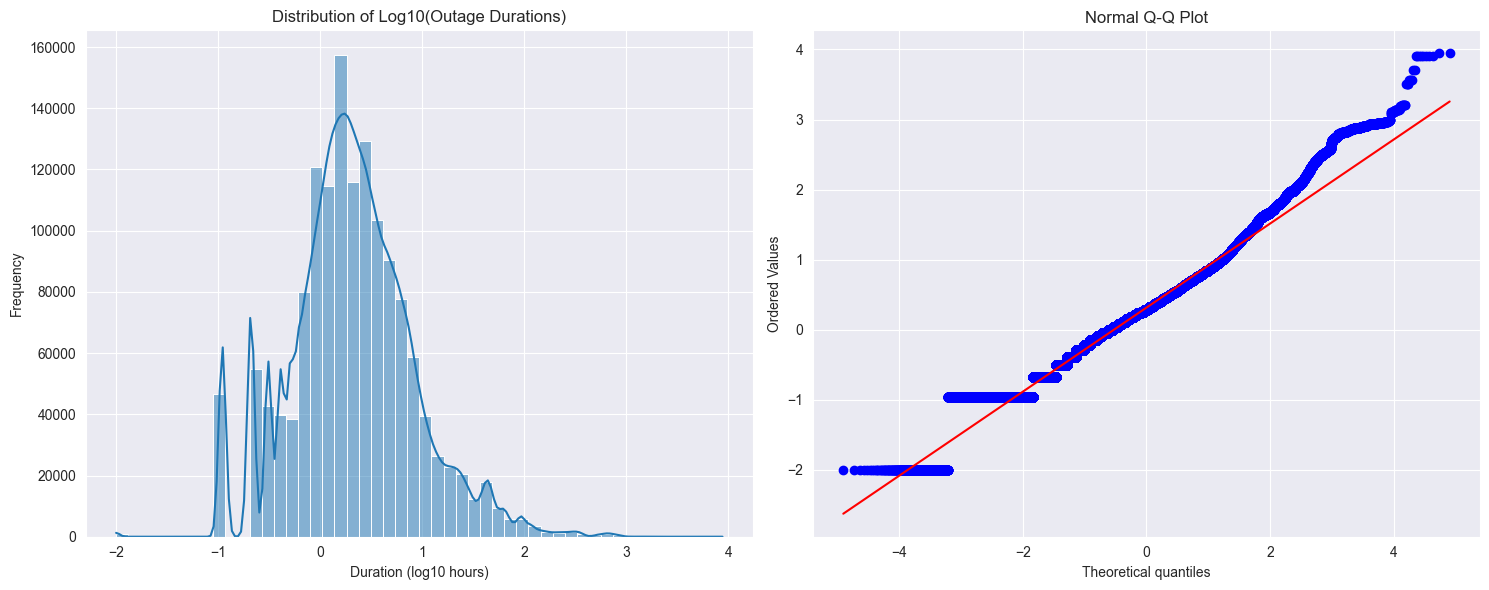

In [138]:
duration = gdf['duration'].round(1)

fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
duration_adj = duration + 0.01
log_duration = np.log10(duration_adj)
sns.histplot(data=log_duration, bins=50, kde=True, ax=ax1)
ax1.set_title('Distribution of Log10(Outage Durations)')
ax1.set_xlabel('Duration (log10 hours)')
ax1.set_ylabel('Frequency')

# QQ Plot
stats.probplot(log_duration, dist="norm", plot=ax2)
ax2.set_title('Normal Q-Q Plot')

plt.tight_layout()

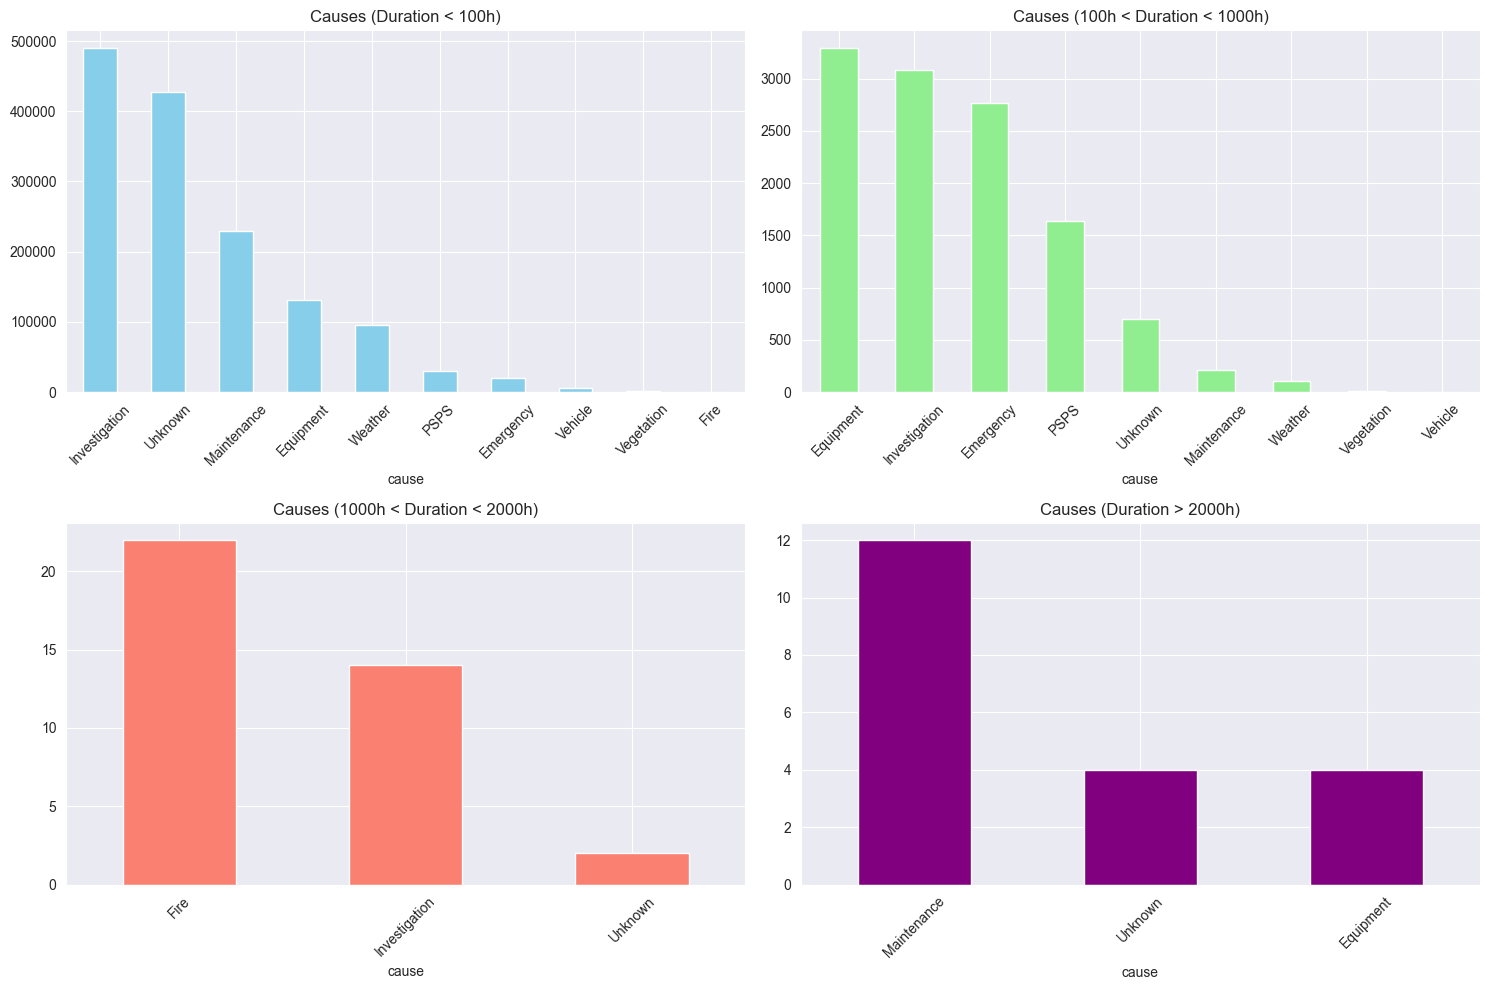

In [141]:
label_map = {
   'Our preliminary determination is that your outage was caused by an equipment issue.': 'Equipment',
   'PG&E is investigating the cause of your outage.': 'Investigation',
   'Our preliminary determination is that your outage was caused by an emergency issue.': 'Emergency',
   'To protect public safety, power in your area has been turned off due to extreme weather conditions with high fire danger. Power will be restored as soon as it is safe to do so.': 'PSPS',
   'Unknown - PG&E will be assessing the cause.': 'Unknown',
   'Our preliminary determination is that your outage was caused by scheduled maintenance work.': 'Maintenance',
   'Our preliminary determination is that your outage was caused by the weather.': 'Weather',
   'Our preliminary determination is that your outage was caused by a fire in your area.': 'Fire',
   'We are clearing vegetation to address potential safety risks in your area.': 'Vegetation',
   'Our preliminary determination is that your outage was caused by a car that hit a pole.': 'Vehicle'
}

fig4, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot for duration > 100
duration_100 = gdf[gdf['duration'] < 100]['cause'].map(label_map).value_counts()
duration_100.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Causes (Duration < 100h)')
ax1.tick_params(axis='x', rotation=45)

# Plot for 100 < duration < 1000
duration_100_1000 = gdf[(gdf['duration'] > 100) & (gdf['duration'] < 1000)]['cause'].map(label_map).value_counts()
duration_100_1000.plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Causes (100h < Duration < 1000h)')
ax2.tick_params(axis='x', rotation=45)

# Plot for 1000 < duration < 2000
duration_1000_2000 = gdf[(gdf['duration'] > 1000) & (gdf['duration'] < 2000)]['cause'].map(label_map).value_counts()
duration_1000_2000.plot(kind='bar', ax=ax3, color='salmon')
ax3.set_title('Causes (1000h < Duration < 2000h)')
ax3.tick_params(axis='x', rotation=45)

# Plot for duration > 2000
duration_2000 = gdf[gdf['duration'] > 2000]['cause'].map(label_map).value_counts()
duration_2000.plot(kind='bar', ax=ax4, color='purple')
ax4.set_title('Causes (Duration > 2000h)')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()

Can I really trust these? The outages seem a little bit too long

I feel like outages with less than 1000 customer have a different behaviour from outages with more than 1000
Regardless,the next step should be creating bins for each of them and analysing them separately.

 What are the types of outages? 
 What should I do with the Investigation or Unknown ones?
 
Ok now is probably a time for weather analysis:
1) Weather code
2) Precipitation
3) Temperature
4) winds_peed


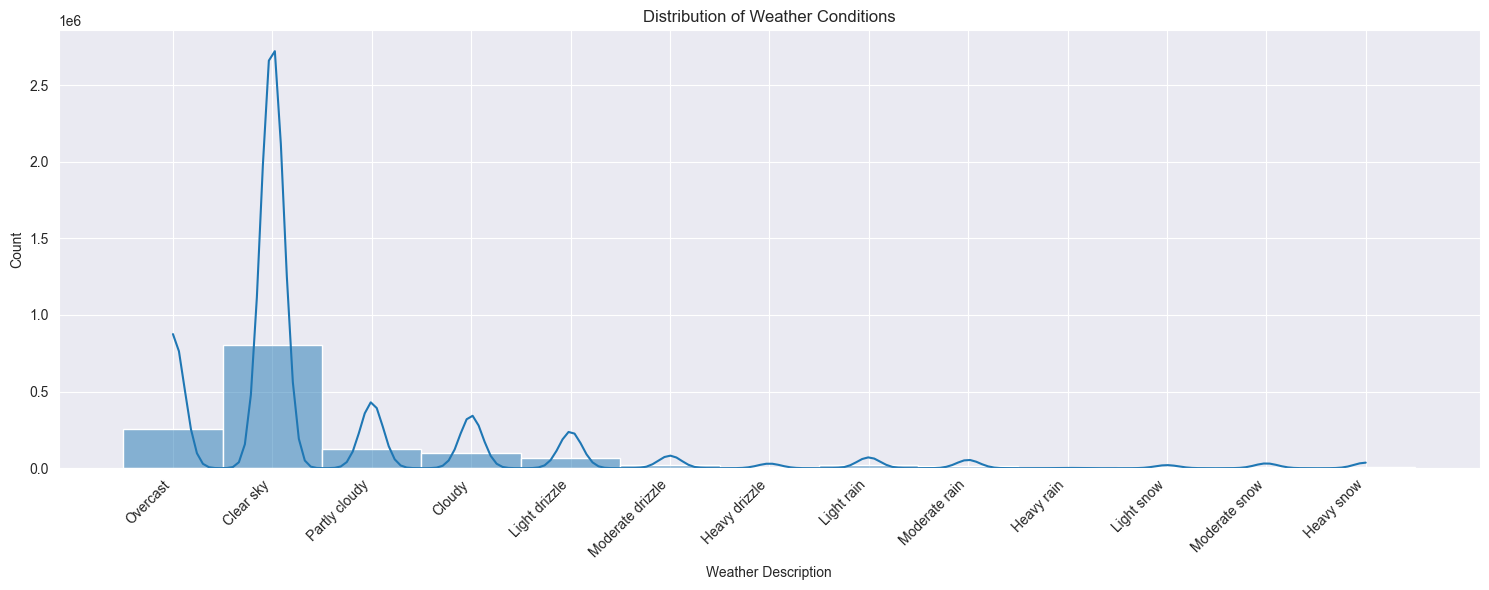

In [144]:
w_code = gdf['weather_code']

# Create mapping dictionary
weather_codes = {
   0: "Clear sky", 1: "Partly cloudy", 2: "Cloudy", 3: "Overcast",
   51: "Light drizzle", 53: "Moderate drizzle", 55: "Heavy drizzle",
   61: "Light rain", 63: "Moderate rain", 65: "Heavy rain",
   71: "Light snow", 73: "Moderate snow", 75: "Heavy snow"
}
w_descriptions = w_code.map(weather_codes)

plt.figure(figsize=(15, 6))
sns.histplot(data=w_descriptions, bins=13, kde=True)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Weather Description')
plt.ylabel('Count')
plt.title('Distribution of Weather Conditions')
plt.tight_layout()

In [ ]:
w_code = gdf['weather_code']

fig5, (ax1, ax2) = plt.subplots(1, 1, figsize=(15, 6))

duration_adj = duration + 0.01
log_duration = np.log10(duration_adj)
sns.histplot(data=w_code, bins=50, kde=True, ax=ax1)

In [ ]:

scaler = RobustScaler()
cust_robust = scaler.fit_transform(gdf['estcustaffected'].values.reshape(-1, 1)).ravel()
dur_robust = scaler.fit_transform(gdf['duration'].values.reshape(-1, 1)).ravel()
cust_norm = normalize([gdf['estcustaffected']])[0] 
dur_norm = normalize([gdf['duration']])[0]

# Plot
fig2, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(data=cust_norm, bins=30, kde=True, color='blue', alpha=0.7, ax=axes[0,0])
axes[0,0].set_title('Normalized Customers Affected')
axes[0,0].set_yscale('log')
axes[0,0].set_xlabel('Normalized Value')
axes[0,0].set_ylabel('Count (log scale)')

sns.histplot(data=dur_norm, bins=30, kde=True, color='blue', alpha=0.7, ax=axes[0,1])
axes[0,1].set_title('Normalized Duration')
axes[0,1].set_yscale('log')
axes[0,1].set_xlabel('Normalized Value')
axes[0,1].set_ylabel('Count (log scale)')

sns.histplot(data=cust_robust, bins=30, kde=True, color='red', alpha=0.7, ax=axes[1,0])
axes[1,0].set_title('Robust Scaled Customers Affected')
axes[1,0].set_yscale('log')
axes[1,0].set_xlabel('Robust Scaled Value')
axes[1,0].set_ylabel('Count (log scale)')

sns.histplot(data=dur_robust, bins=30, kde=True, color='red', alpha=0.7, ax=axes[1,1])
axes[1,1].set_title('Robust Scaled Duration')
axes[1,1].set_yscale('log')
axes[1,1].set_xlabel('Robust Scaled Value')
axes[1,1].set_ylabel('Count (log scale)')

plt.tight_layout()

In [74]:
gdf[['estcustaffected', 'duration']].describe()

,estcustaffected,duration
count,1.442498e+06,1.442498e+06
mean,5.633423e+01,8.135224e+00
std,3.956634e+02,4.688482e+02
min,0.000000e+00,7.222222e-03
25%,1.000000e+00,8.922222e-01
50%,1.000000e+00,1.946389e+00
75%,9.000000e+00,4.631389e+00
max,7.796000e+04,2.805207e+05


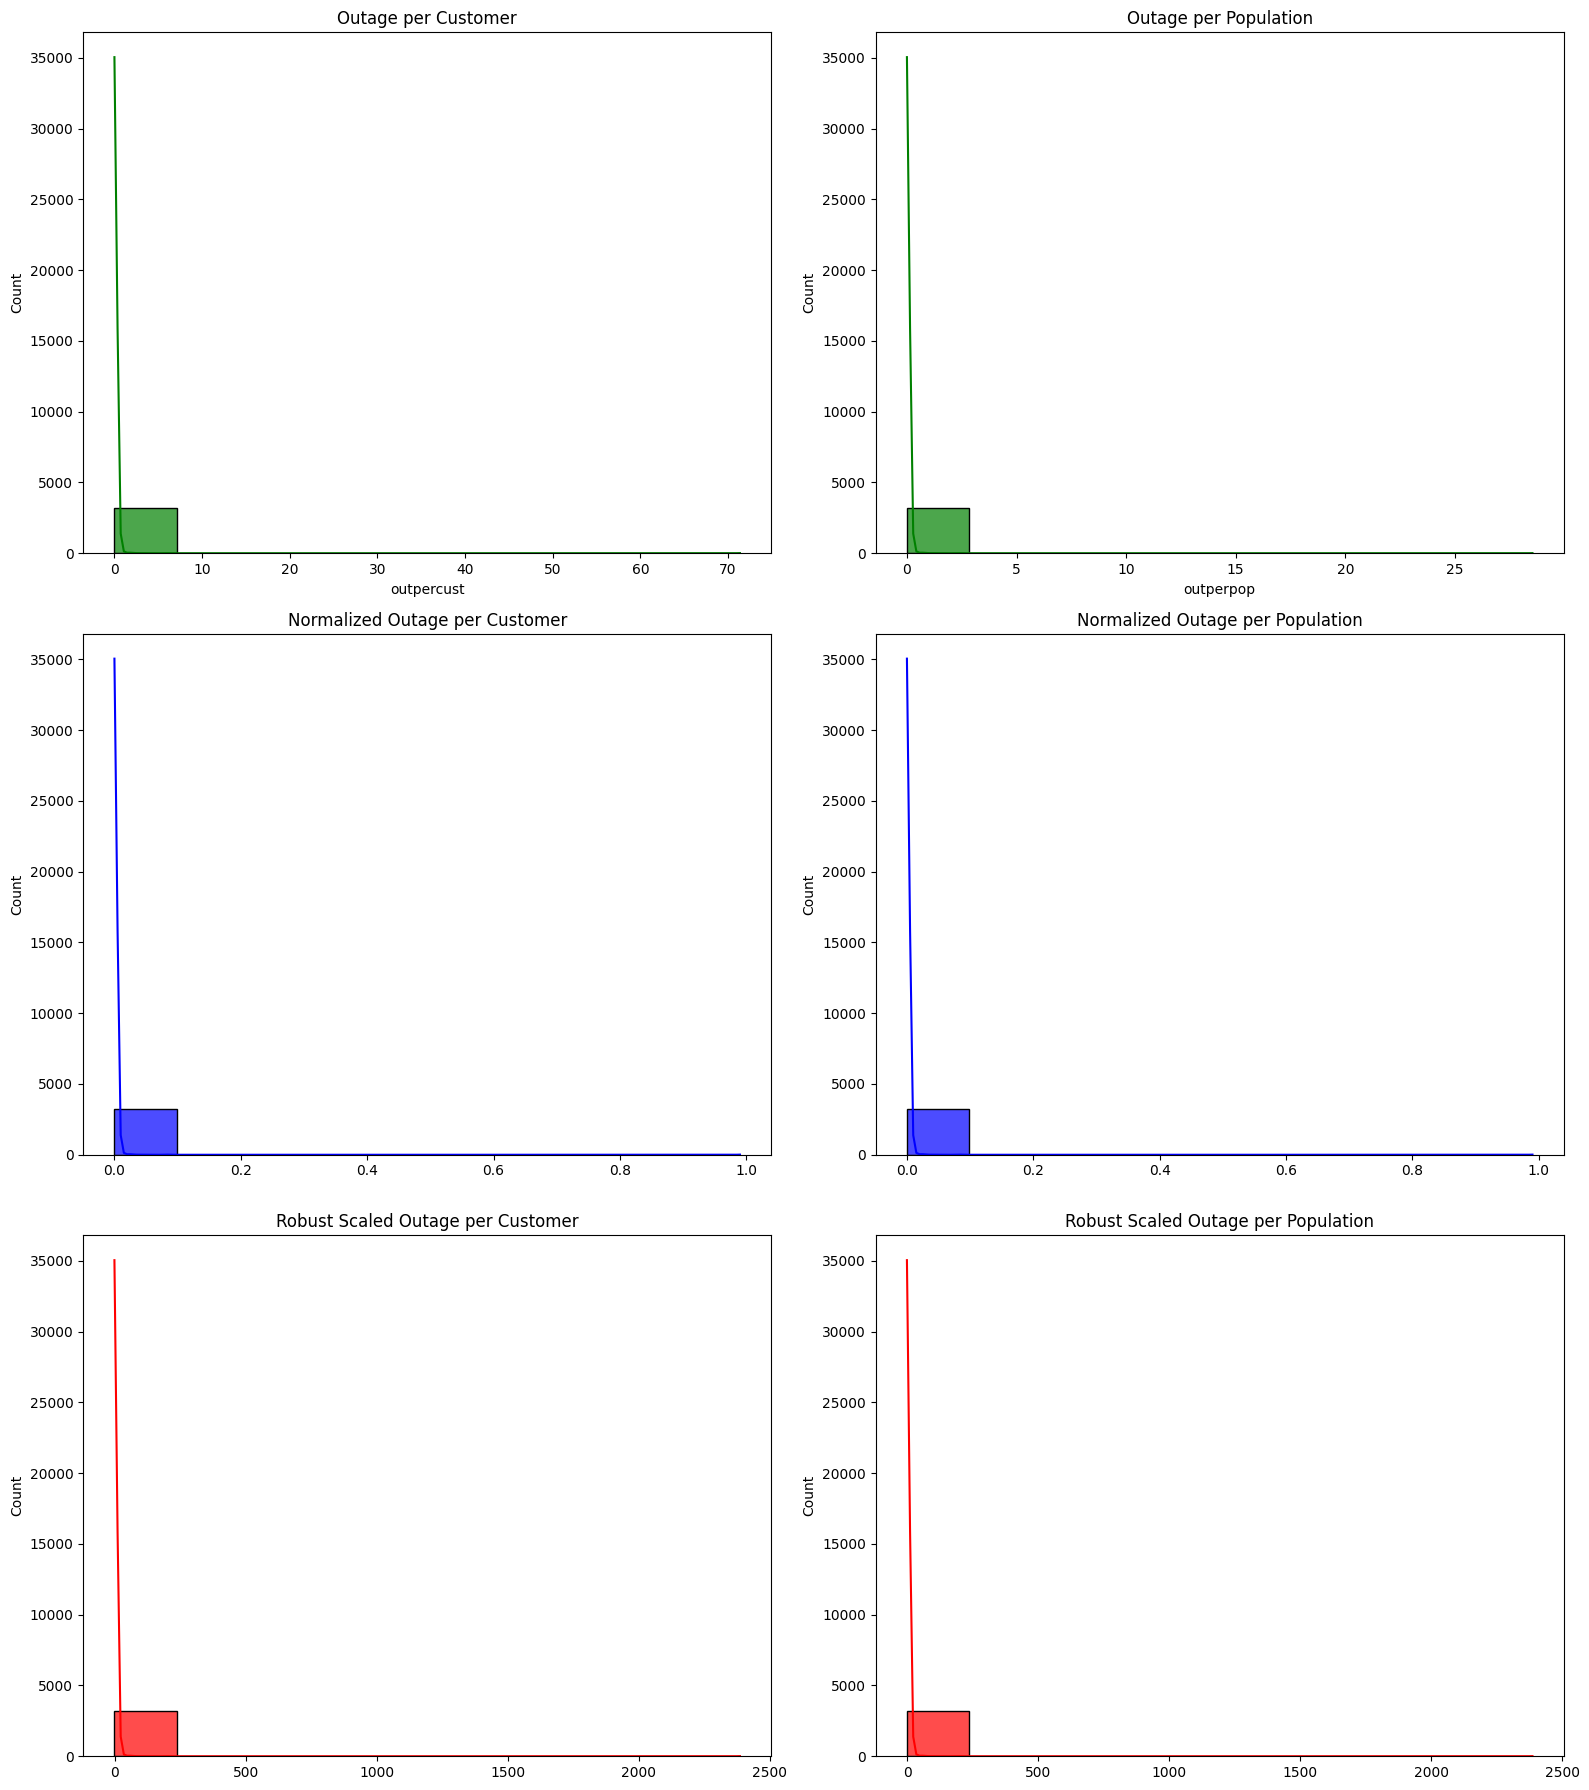

In [95]:
d = gdf.groupby("GEOID").agg({
   'estcustaffected': 'mean',
   'duration': 'mean',
   'total_population': 'max', 
    'regionname': 'first',
    'geometry': 'first'
    
})
# Transform data
scaler = RobustScaler()
d['estcust'] = d['total_population'] * 0.4
d['outpercust'] = d['estcustaffected'] / d['estcust'] 
d['outperpop'] = d['estcustaffected'] / d['total_population']

# Transform data with both scalers
cust_robust = scaler.fit_transform(d['outpercust'].values.reshape(-1, 1)).ravel()
pop_robust = scaler.fit_transform(d['outperpop'].values.reshape(-1, 1)).ravel()
cust_norm = normalize([d['outpercust']])[0]
pop_norm = normalize([d['outperpop']])[0]

# Plot
fig3, axes = plt.subplots(3, 2, figsize=(16, 18))

# Raw data
sns.histplot(data=d['outpercust'], bins=10, kde=True, color='green', alpha=0.7, ax=axes[0,0])
axes[0,0].set_title('Outage per Customer')

sns.histplot(data=d['outperpop'], bins=10, kde=True, color='green', alpha=0.7, ax=axes[0,1])
axes[0,1].set_title('Outage per Population')

# Normalized data
sns.histplot(data=cust_norm, bins=10, kde=True, color='blue', alpha=0.7, ax=axes[1,0])
axes[1,0].set_title('Normalized Outage per Customer')

sns.histplot(data=pop_norm, bins=10, kde=True, color='blue', alpha=0.7, ax=axes[1,1])
axes[1,1].set_title('Normalized Outage per Population')

# Robust scaled data
sns.histplot(data=cust_robust, bins=10, kde=True, color='red', alpha=0.7, ax=axes[2,0])
axes[2,0].set_title('Robust Scaled Outage per Customer')

sns.histplot(data=pop_robust, bins=10, kde=True, color='red', alpha=0.7, ax=axes[2,1])
axes[2,1].set_title('Robust Scaled Outage per Population')

plt.tight_layout()


In [92]:
print(d['estcust'].sum(), d['total_population'].sum())
d.describe()

5544320.0 13860800.0


,estcustaffected,duration,total_population,regionname,estcust,outpercust,outperpop
count,3219.000000,3219.000000,3219.000000,3219.000000,3219.000000,3219.000000,3219.000000
mean,61.403676,4.989775,4305.933520,1.574713,1722.373408,0.068947,0.027579
std,135.956331,13.205067,1640.820867,1.220396,656.328347,1.268581,0.507432
min,1.000000,0.188333,4.000000,1.000000,1.600000,0.000175,0.000070
25%,14.569444,2.743335,3182.000000,1.000000,1272.800000,0.008377,0.003351
50%,27.613636,3.577152,4169.000000,1.000000,1667.600000,0.016797,0.006719
75%,56.681044,4.960269,5350.000000,2.000000,2140.000000,0.038269,0.015307
max,2631.125000,694.781903,14272.000000,13.000000,5708.800000,71.354167,28.541667


Robust Regression and Normalization don't seem to be working, when I estimate number of customer the numbers decrease significantly

In [96]:
d[d['outpercust'] == d['outpercust'].max()]

,estcustaffected,duration,total_population,regionname,geometry,estcust,outpercust,outperpop
GEOID,,,,,,,,
06095980000,114.166667,15.828843,4.0,Fairfield,POINT (-121.96481 38.26391),1.6,71.354167,28.541667
